In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic') 


In [2]:
# datetime을 index로 옮겨주는 함수
def datetime_revise(df):
    # python datetime에서는 시간을 0~23시까지밖에 인식을 못하기 때문에 1을 빼준다.
    df.index = pd.to_datetime(df['datetime']) + pd.to_timedelta(df['hour'], unit='hours')
    df.drop(['year', 'month', 'day', 'weekday', 'hour', 'datetime'], axis=1, inplace=True)
    return df

In [3]:
# 시계열 분석을 위해 target값만을 뽑음
def make_df(df, colname):
    df = df.query(f'supplys == "{colname}"')
    return df['target']

In [4]:
# upsamplingm downsampling해줄 수 있도록 하는 함수
def set_freq(df, freq='m'):
    tmp =  pd.DataFrame(df.resample(freq, closed='right').sum())
    return tmp[tmp['target'] != 0.0]

In [5]:
total = pd.read_csv('data/no_outlier_data.csv')
total = datetime_revise(total)
total

,supplys,avg_temp,mini_temp,max_temp,target
2013-01-01 01:00:00,A,-3.2,-9.1,2.6,2497.129
2013-01-01 02:00:00,A,-3.2,-9.1,2.6,2363.265
2013-01-01 03:00:00,A,-3.2,-9.1,2.6,2258.505
2013-01-01 04:00:00,A,-3.2,-9.1,2.6,2243.969
2013-01-01 05:00:00,A,-3.2,-9.1,2.6,2344.105
...,...,...,...,...,...
2018-12-31 20:00:00,H,-3.2,-9.9,4.0,681.033
2018-12-31 21:00:00,H,-3.2,-9.9,4.0,669.961
2018-12-31 22:00:00,H,-3.2,-9.9,4.0,657.941
2018-12-31 23:00:00,H,-3.2,-9.9,4.0,610.953


In [6]:
original = pd.read_csv('data/no_outlier_data.csv')
original

,supplys,year,month,day,weekday,hour,datetime,avg_temp,mini_temp,max_temp,target
0,A,2013,1,1,1,1,2013-01-01,-3.2,-9.1,2.6,2497.129
1,A,2013,1,1,1,2,2013-01-01,-3.2,-9.1,2.6,2363.265
2,A,2013,1,1,1,3,2013-01-01,-3.2,-9.1,2.6,2258.505
3,A,2013,1,1,1,4,2013-01-01,-3.2,-9.1,2.6,2243.969
4,A,2013,1,1,1,5,2013-01-01,-3.2,-9.1,2.6,2344.105
...,...,...,...,...,...,...,...,...,...,...,...
367915,H,2018,12,31,0,20,2018-12-31,-3.2,-9.9,4.0,681.033
367916,H,2018,12,31,0,21,2018-12-31,-3.2,-9.9,4.0,669.961
367917,H,2018,12,31,0,22,2018-12-31,-3.2,-9.9,4.0,657.941
367918,H,2018,12,31,0,23,2018-12-31,-3.2,-9.9,4.0,610.953


In [7]:
# total.to_csv('data_time_index.csv', index=True)

In [8]:
# 공급사 이름
supply_name_list = [n for n in total['supplys'].unique().tolist()]
supply_name_list

['A', 'B', 'C', 'D', 'E', 'G', 'H']

# 1. 시계열 데이터 탐색
 - 현재 시계열 데이터가 어떤 성질을 가지고 있는지 판단함.
 - 눈으로 봐도 빌별 데이터 기준 1년 주기의 주기성이 반복되는 것을 확인할 수 있었지만, 수업 등에서 배웠던 시계열 분석을 통해 수치적으로 파악함

In [9]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

In [10]:
# 한 번에 분석하기 용이하도록 각 공급사별로 일별 공급 데이터만 담긴 series를 따로 저장
colname = total['supplys'].unique().tolist()

## 1. 일 단위 탐색

In [11]:
# 각 공급사별로 일 단위 데이터로 down-sampling한 데이터
day_time_series = [set_freq(make_df(total, col), freq='d') for col in colname]
day_time_series[1]

,target
2013-01-01,52242.472
2013-01-02,62717.832
2013-01-03,67122.712
2013-01-04,65336.712
2013-01-05,59367.512
...,...
2018-12-27,58374.700
2018-12-28,62618.412
2018-12-29,57900.317
2018-12-30,55502.179


### 1-1 일별 시계열 데이터를 도식화 (1년만 표시)
- 겨울에는 사용량이 크고, 여름에는 사용량이 작음을 알 수 있음

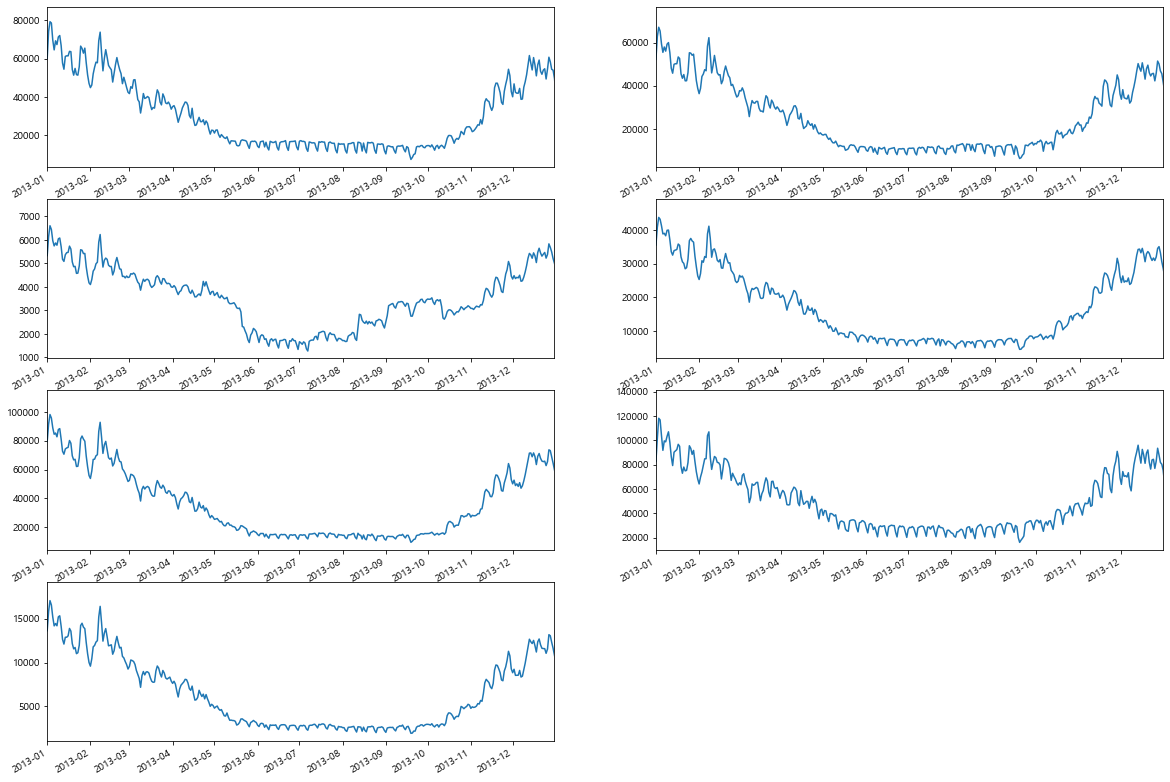

In [12]:
# A~H사 데이터 그림
plt.subplots(figsize=(20, 15))

for idx, t_df in enumerate(day_time_series):
    ax = plt.subplot(4, 2, idx+1)
    t_df['target'].plot(xlim=[datetime.date(2013, 1, 1), datetime.date(2013, 12, 31)])

### 1-2 잔차진단 ( 넣어야할까 빼야할까...)
- 잔차는 Y - Trend - Seasonal에서 만들어지는데, 역으로 생각하면 만약 잔차에 trend나 seasonal 특성이 남아있으면, 완벽하게 trend, seasonality 부분이 추출되지 않았음을 의미
- 잔차는 백색잡음(white noise) 특성을 가져야 함
- 백색잡음 특징 : 평균 0, 분산 일정, 정규분포 따라야 함, 자기상관도함수 값 0이어야
- 출처 : https://dsbook.tistory.com/265?category=841791

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

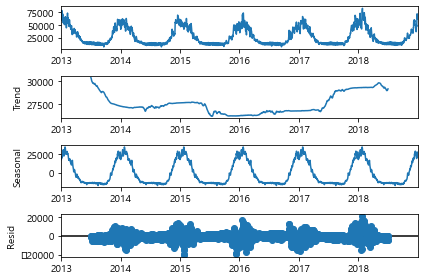

In [14]:
# 분해하보자
result = seasonal_decompose(day_time_series[0], model='additive', period=365)
result.plot()
plt.show()

# 딱 봐도 잔차에서 패턴이 있는 것을 볼 수 있다.

In [15]:
# 잔차 추출
residual = result.resid
# residual.isna().sum()
residual.fillna(0, inplace=True)

In [16]:
# 1. 잔차의 정규분포 test
from scipy.stats import shapiro

# p-value가 0.05보다 작으므로 정규분포가 아니라는 검정 
shapiro(residual)

(0.8981109857559204, 7.275025769573375e-36)

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [18]:
acorr_ljungbox(residual, return_df=True)

,lb_stat,lb_pvalue
1,1290.517130,1.300134e-282
2,1717.085475,0.000000e+00
3,1864.136851,0.000000e+00
4,1920.797928,0.000000e+00
5,1951.842104,0.000000e+00
6,2032.975071,0.000000e+00
7,2176.795609,0.000000e+00
8,2209.685383,0.000000e+00
9,2211.943560,0.000000e+00
10,2226.185392,0.000000e+00


### 1-2 ADF TEST를 통한 단위근검정
- p-value가 유의수준보다 작으면 귀무가설(단위근이 있다) 기각
- 주의할 점 : 단위근이 있으면 비정상이라고 할 수 있지만, 단위근이 없다고 해서 정상 시계열은 아니다
- 추가적인 검증이 필요함

### ACF / PACF
- 일 단위의 시계열
- acf가 천천히 감소하고 있는 걸 보니 정상시계열이 아니라도 추정 => 차분 필요

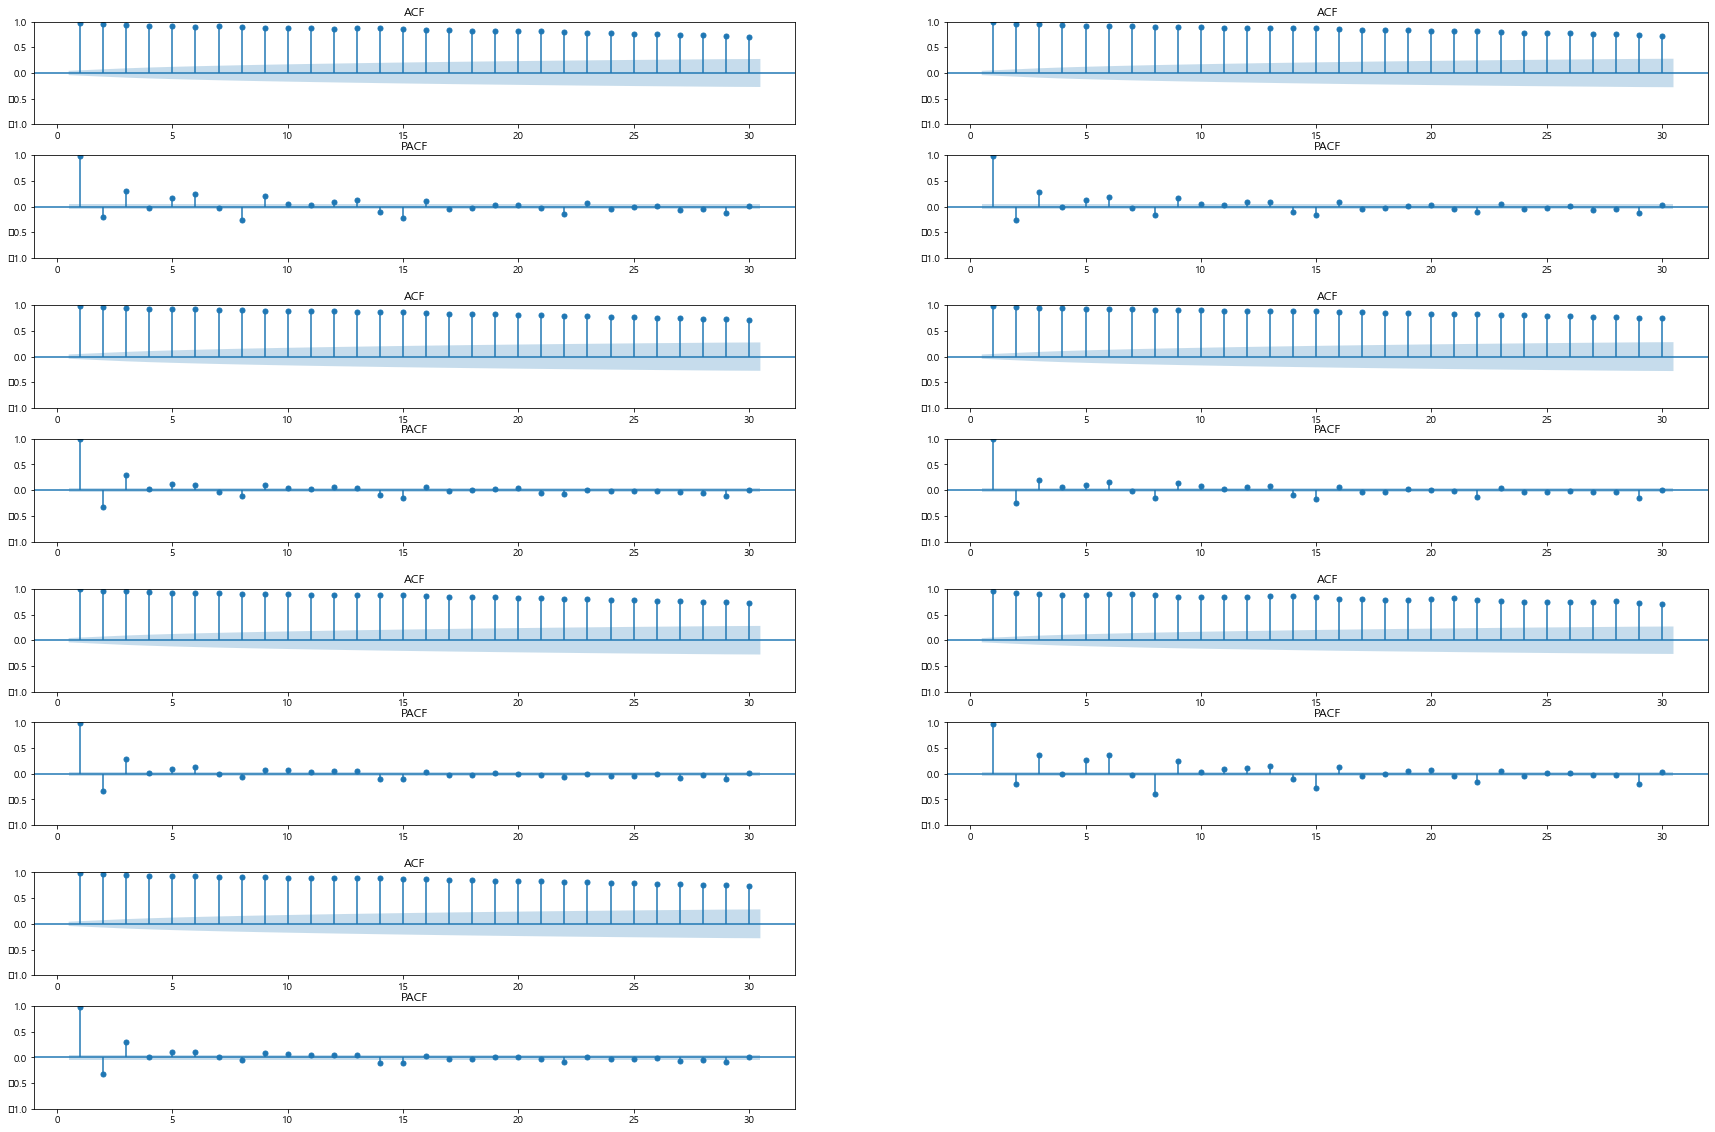

In [19]:
import matplotlib.gridspec as gridspec

# Grid하기 위한 작업
fig = plt.figure(figsize=(30, 20))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)

for idx, t_df in enumerate(day_time_series):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[idx], wspace=0.3, hspace=0.3)
    
    # Grid내부에 acf, pacf를 그릴 subplot 생성
    ax1 = plt.Subplot(fig, inner[0])
    ax2 = plt.Subplot(fig, inner[1])
    
    # acf draw
    sgt.plot_acf(t_df['target'], lags = 30, zero = False, ax=ax1)
    ax1.set_title("ACF")
    
    # pacf draw
    sgt.plot_pacf(t_df['target'], lags = 30, zero = False, method = ('ols'), ax=ax2)
    ax2.set_title("PACF")
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)

fig.show()

### ADF Test

In [20]:
# 유의수준 설정
alpha = 0.001

print('')
for idx, t_df in enumerate(day_time_series):

    p_value = sts.adfuller(t_df['target'])[1]
    
    # 귀무가설 기각
    if p_value < alpha:
        print(f'{supply_name_list[idx]}는 p-value({round(p_value, 3)})가 유의수준 {alpha}보다 낮으므로 단위근이 존재하지 않습니다')
    else:
        print(f'(비정상 시계열) {supply_name_list[idx]}는 p-value({round(p_value, 3)})가 유의수준 {alpha}보다 높으므로 단위근이 존재합니다')


(비정상 시계열) A는 p-value(0.023)가 유의수준 0.001보다 높으므로 단위근이 존재합니다
(비정상 시계열) B는 p-value(0.018)가 유의수준 0.001보다 높으므로 단위근이 존재합니다
(비정상 시계열) C는 p-value(0.046)가 유의수준 0.001보다 높으므로 단위근이 존재합니다
(비정상 시계열) D는 p-value(0.095)가 유의수준 0.001보다 높으므로 단위근이 존재합니다
(비정상 시계열) E는 p-value(0.015)가 유의수준 0.001보다 높으므로 단위근이 존재합니다
(비정상 시계열) G는 p-value(0.105)가 유의수준 0.001보다 높으므로 단위근이 존재합니다
(비정상 시계열) H는 p-value(0.014)가 유의수준 0.001보다 높으므로 단위근이 존재합니다


### 차분 후 ACF, PACF
- 1차 차분만을 통해서도 단위근이 존재하지 않는 것을 만들 수 있다.

In [21]:
day_time_series_diff = []
for t_df in day_time_series:
    tmp_df = np.log(t_df)
    tmp_df = t_df.diff(1)
    tmp_df.dropna(axis=0, inplace=True)
    day_time_series_diff.append(tmp_df)
day_time_series_diff[0]

,target
2013-01-02,14110.992
2013-01-03,5050.072
2013-01-04,-692.872
2013-01-05,-8936.192
2013-01-06,-5087.240
...,...
2018-12-27,14129.595
2018-12-28,5297.297
2018-12-29,-7641.547
2018-12-30,-2429.409


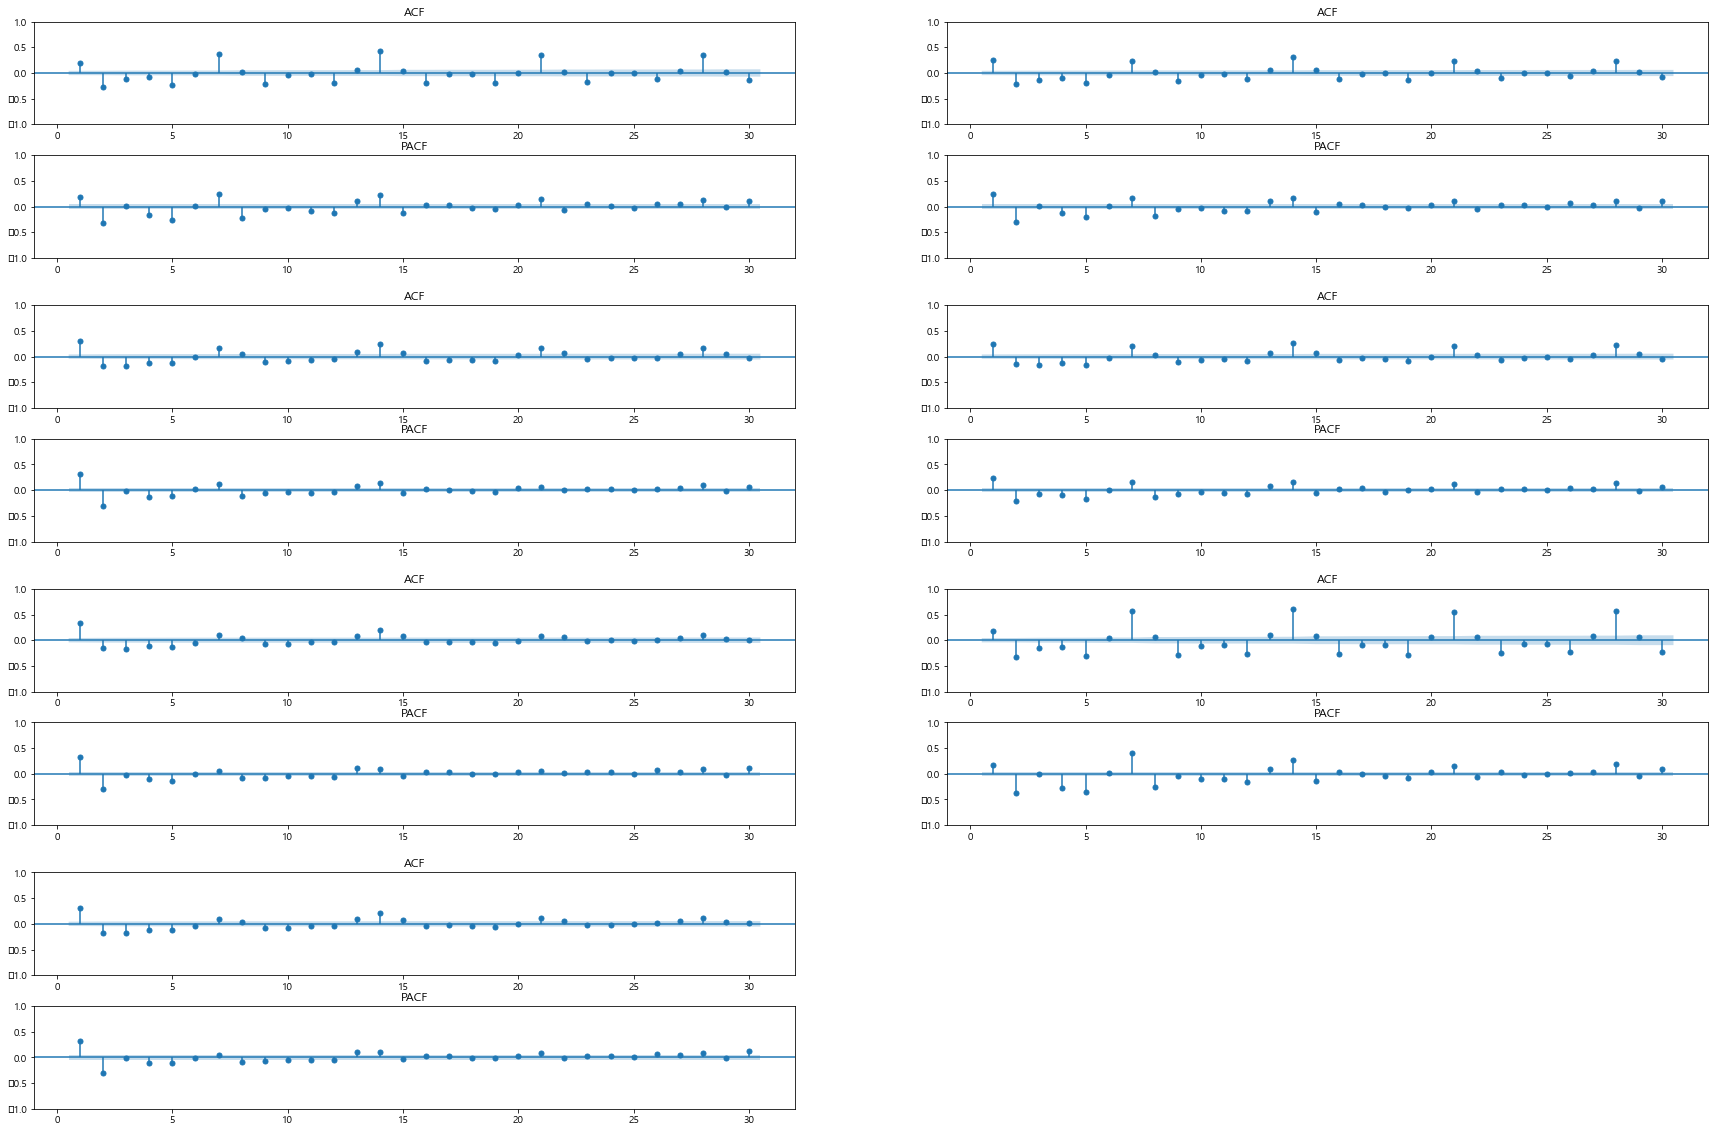

In [22]:
# Grid하기 위한 작업
fig = plt.figure(figsize=(30, 20))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)

for idx, t_df in enumerate(day_time_series_diff):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[idx], wspace=0.3, hspace=0.3)
    
    # Grid내부에 acf, pacf를 그릴 subplot 생성
    ax1 = plt.Subplot(fig, inner[0])
    ax2 = plt.Subplot(fig, inner[1])
    
    # acf drawz
    sgt.plot_acf(t_df['target'], lags = 30, zero = False, ax=ax1)
    ax1.set_title("ACF")
    
    # pacf draw
    sgt.plot_pacf(t_df['target'], lags = 30, zero = False, method = ('ols'), ax=ax2)
    ax2.set_title("PACF")
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)

fig.show()

In [23]:
# 1차 차분만으로도 단위근이 존재하지 않는 것을 확인할 수 있다
alpha = 0.001

print('')
for idx, t_df in enumerate(day_time_series_diff):

    p_value = sts.adfuller(t_df)[1]
    
    # 귀무가설 기각
    if p_value < alpha:
        print(f'{supply_name_list[idx]}는 p-value({round(p_value, 3)})가 유의수준 {alpha}보다 낮으므로 단위근이 존재하지 않습니다')
    else:
        print(f'(비정상 시계열) {supply_name_list[idx]}는 p-value({round(p_value, 3)})가 유의수준 {alpha}보다 높으므로 단위근이 존재합니다')


A는 p-value(0.0)가 유의수준 0.001보다 낮으므로 단위근이 존재하지 않습니다
B는 p-value(0.0)가 유의수준 0.001보다 낮으므로 단위근이 존재하지 않습니다
C는 p-value(0.0)가 유의수준 0.001보다 낮으므로 단위근이 존재하지 않습니다
D는 p-value(0.0)가 유의수준 0.001보다 낮으므로 단위근이 존재하지 않습니다
E는 p-value(0.0)가 유의수준 0.001보다 낮으므로 단위근이 존재하지 않습니다
G는 p-value(0.0)가 유의수준 0.001보다 낮으므로 단위근이 존재하지 않습니다
H는 p-value(0.0)가 유의수준 0.001보다 낮으므로 단위근이 존재하지 않습니다


# 2. ARIMA 모델 적용
- 일 단위 이하 시계열 데이터에 적용해 보았을 때, AIC가 40,000이상의 값을 가지며 처리속도 문제로 인해 진행 불가하다 판단
- 원 단위 시계열 데이터로 적용해 봄

In [104]:
from pmdarima.arima import auto_arima

In [29]:
# 우선 A사만 해본다
# 월 단위 예측
month_time_series = [set_freq(make_df(total, col), freq='m') for col in colname]
month_time_series[1]

,target
2013-01-31,1613602.099
2013-02-28,1275412.416
2013-03-31,992980.392
2013-04-30,715165.216
2013-05-31,400185.832
...,...
2018-09-30,285643.943
2018-10-31,518997.285
2018-11-30,821980.851
2018-12-31,1414916.843


In [ ]:
A_df = month_time_series[0]
index = int(len(A_df) * 0.8)

# train데이터와 test 데이터를 8:2 비율로 나누어서 사용
train, test = A_df[:index], A_df[index:]
train.head()

In [31]:
# 오부 라이브러리를 사용해서 자동적으로 parameter 찾아줌
auto_arima_model = auto_arima(train, start_p=1, start_q=1,
                  max_p=5, max_q=1, m=12,
                  seasonal=True,
                  d=1, D=1,
                  max_d = 3, max_D=3,
                  trace=True,
                  start_Q=0,
                  max_P = 5, max_Q=1,
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=False,)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1187.685, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1982.292, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1192.681, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1199.129, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1285.751, Time=0.20 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1284.240, Time=0.31 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=1172.290, Time=0.71 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=1173.803, Time=0.81 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1174.290, Time=1.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1189.062, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1191.002, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1191.032, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1

In [32]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   58
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -575.895
Date:                             Fri, 26 Nov 2021   AIC                           1159.789
Time:                                     17:41:32   BIC                           1167.016
Sample:                                          0   HQIC                          1162.483
                                              - 58                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1028      0.040     -2.596      0.009      -0.180      -0.025
ar.S.L12      -0.1598      0.049     -3.291      0.001      -0.255      -0.065
ar.S.L24      -0.2283      0.054     -4.200      0.000      -0.335      -0.122
sigma2      8.621e+09      8e-13   1.08e+22      0.000    8.62e+09    8.62e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                46.51
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             1.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.32e+37. Standard errors may be unstable.
"""

In [33]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [94]:
# 예측
from sklearn.metrics import r2_score


prediction= auto_arima_model.predict(len(test), return_coef_int=True)
predicted_value = prediction
predict_index = list(test.index)
# r2 score 계산
r2 = r2_score(test, predicted_value)
r2

0.377568278451307

In [35]:
# MAPE 계산
MAPE(np.array(test['target'][:-1]).reshape(1,-1), predicted_value[:-1])

10.76376533453388

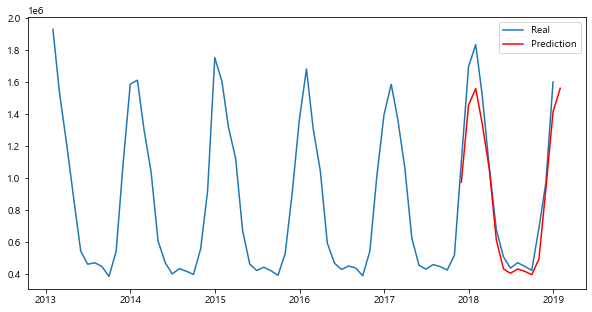

In [36]:
# 훈련시키지 않은 2018년의 데이터의 실제 값과 예측 값 비교
plt.figure(figsize=(10,5))
plt.plot(A_df['target'][:-1], label='Real')
plt.plot(predict_index, predicted_value, label='Prediction', color='red')
plt.legend()

# 3. 지수평활법 적용

## 3-1 일 단위 지수평활법 적용

In [105]:
# 지수평활법 라이브러리
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [106]:
# test 데이터를 향후 3개월 예측할 수 있도록 함
A_df = day_time_series[0]
train, test = A_df[:-270], A_df[-270:]

In [107]:
# 일 단위 데이터이고, 1년 단위로 cycle이 진행되기 떼문에 seasonal periods에 365를 입력
holt_additive = ExponentialSmoothing(train, trend='add', seasonal="add", seasonal_periods=365).fit()

C:\Users\park123\anaconda3\envs\gas_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\park123\anaconda3\envs\gas_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [108]:
# 향후 270일을 예측
predicted_value = holt_additive.forecast(270)
predict_index = test.index

C:\Users\park123\anaconda3\envs\gas_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


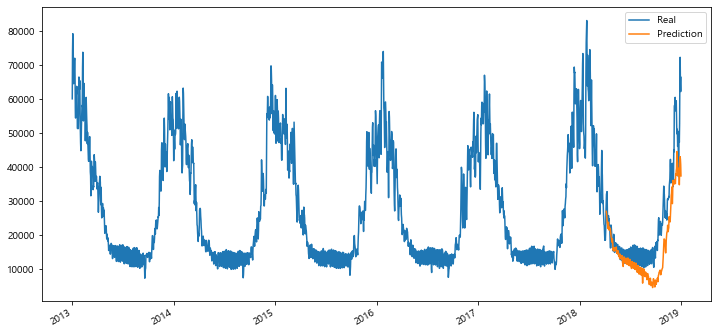

In [109]:
fig, ax = plt.subplots(figsize=(12, 6))
A_df['target'].plot(ax=ax, label='Real')
ax.plot(predict_index, predicted_value, label='Prediction')
plt.legend()

In [110]:
MAPE(test.values.reshape(1,-1), predicted_value.values)

30.489394419985587

In [111]:
# 시간 단위

In [112]:
# 각 공급사별로 일 단위 데이터로 down-sampling한 데이터
hour_time_series = [set_freq(make_df(total, col), freq='h') for col in colname]
hour_time_series[1]

,target
2013-01-01 00:00:00,2169.093
2013-01-01 01:00:00,2051.733
2013-01-01 02:00:00,1923.253
2013-01-01 03:00:00,1927.253
2013-01-01 04:00:00,2047.333
...,...
2018-12-31 19:00:00,2668.688
2018-12-31 20:00:00,2606.681
2018-12-31 21:00:00,2540.169
2018-12-31 22:00:00,2407.945


In [113]:
A_df = hour_time_series[0]
train, test = A_df[:-8760], A_df[-8760:]

In [114]:
# Holt-Winters 가법모형을 통해 예측을 시도해 봄
holt_additive = ExponentialSmoothing(train, trend='add', seasonal="add", seasonal_periods=24).fit()

C:\Users\park123\anaconda3\envs\gas_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\park123\anaconda3\envs\gas_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [115]:
predicted_value = holt_additive.forecast(8760)
predict_index = test.index

C:\Users\park123\anaconda3\envs\gas_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


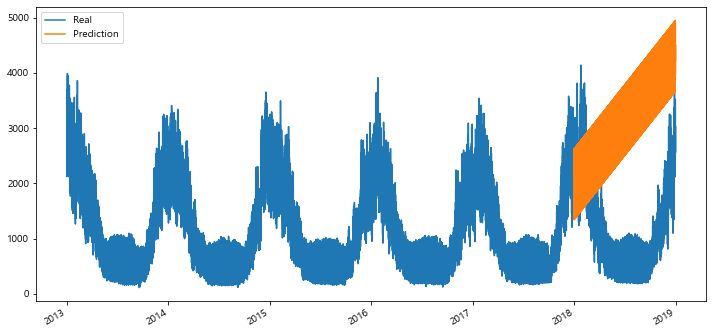

In [116]:
fig, ax = plt.subplots(figsize=(12, 6))
A_df['target'].plot(ax=ax, label='Real')
ax.plot(predict_index, predicted_value, label='Prediction')
plt.legend()

In [117]:
MAPE(test.values.reshape(1,-1), predicted_value.values)

292.6861123295732

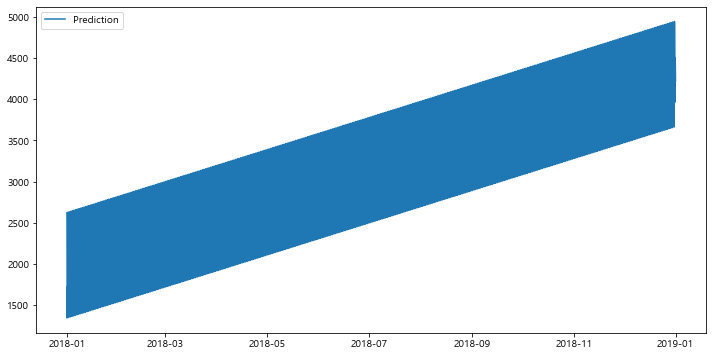

In [118]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(predict_index, predicted_value, label='Prediction')
plt.legend()